In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('adult_analysis').getOrCreate()
df = spark.read.csv('adult.csv', inferSchema = True, header=True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- educational-num: integer (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- capital-gain: integer (nullable = true)
 |-- capital-loss: integer (nullable = true)
 |-- hours-per-week: integer (nullable = true)
 |-- native-country: string (nullable = true)
 |-- income: string (nullable = true)



### 保存原始数据集的列

In [2]:
columns = df.columns

In [3]:
df.show(5)

+---+---------+------+------------+---------------+------------------+-----------------+------------+-----+------+------------+------------+--------------+--------------+------+
|age|workclass|fnlwgt|   education|educational-num|    marital-status|       occupation|relationship| race|gender|capital-gain|capital-loss|hours-per-week|native-country|income|
+---+---------+------+------------+---------------+------------------+-----------------+------------+-----+------+------------+------------+--------------+--------------+------+
| 25|  Private|226802|        11th|              7|     Never-married|Machine-op-inspct|   Own-child|Black|  Male|           0|           0|            40| United-States| <=50K|
| 38|  Private| 89814|     HS-grad|              9|Married-civ-spouse|  Farming-fishing|     Husband|White|  Male|           0|           0|            50| United-States| <=50K|
| 28|Local-gov|336951|  Assoc-acdm|             12|Married-civ-spouse|  Protective-serv|     Husband|White|  M

### Pandas dataframe展示效果比Spark DataFrame.show()方法更好

In [4]:
import pandas as pd
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
age,25,38,28,44,18
workclass,Private,Private,Local-gov,Private,?
fnlwgt,226802,89814,336951,160323,103497
education,11th,HS-grad,Assoc-acdm,Some-college,Some-college
educational-num,7,9,12,10,10
marital-status,Never-married,Married-civ-spouse,Married-civ-spouse,Married-civ-spouse,Never-married
occupation,Machine-op-inspct,Farming-fishing,Protective-serv,Machine-op-inspct,?
relationship,Own-child,Husband,Husband,Husband,Own-child
race,Black,White,White,Black,White
gender,Male,Male,Male,Male,Female


### 类别存在不平衡的现象

In [5]:
df.groupby('income').count().toPandas()

,income,count
0,<=50K,37155
1,>50K,11687


### 数值变量

In [6]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,48842,38.64358543876172,13.710509934443518,17,90
fnlwgt,48842,189664.13459727284,105604.02542315758,12285,1490400
educational-num,48842,10.078088530363212,2.570972755592256,1,16
capital-gain,48842,1079.0676262233324,7452.019057655418,0,99999
capital-loss,48842,87.50231358257237,403.00455212435924,0,4356
hours-per-week,48842,40.422382375824085,12.391444024252296,1,99


### 相关性矩阵(Correlations)

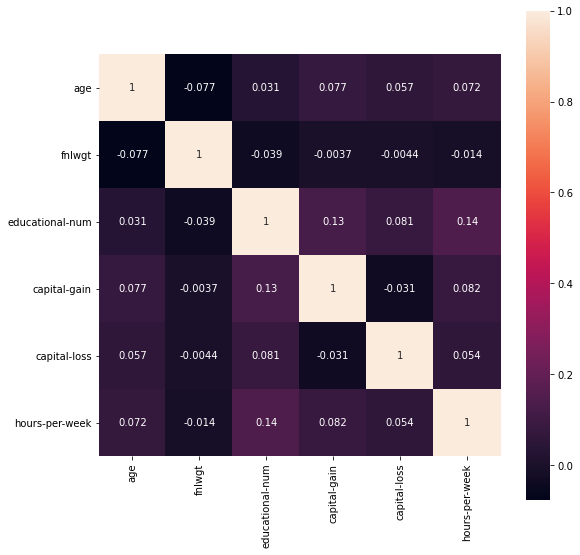

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.toPandas().corr()
plt.subplots(figsize=(9, 9)) # 设置画面大小
sns.heatmap(corr, annot=True, square=True)
fig = plt.gcf()
fig.savefig('HeatMap.png',dpi=300,bbox_inches='tight')

### 不进行归一化处理

In [8]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

categoricalColumns = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "gender", "native-country"]
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'income', outputCol = 'label')
stages += [label_stringIdx]

numericCols = ["age", "fnlwgt", "educational-num", "capital-gain", "capital-loss", "hours-per-week"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

### 进行归一化处理

In [9]:
# from pyspark.ml import Pipeline
# from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
# from pyspark.ml.feature import MinMaxScaler, Normalizer, MaxAbsScaler

# categoricalColumns = ["workclass", "education", "marital-status", "occupation", "relationship", "race", "gender", "native-country"]
# stages = []

# for categoricalCol in categoricalColumns:
#     stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
#     encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
#     stages += [stringIndexer, encoder]

# label_stringIdx = StringIndexer(inputCol = 'income', outputCol = 'label')
# stages += [label_stringIdx]

# numericCols = ["age", "fnlwgt", "educational-num", "capital-gain", "capital-loss", "hours-per-week"]

# assembler1 = VectorAssembler(inputCols=numericCols, outputCol="raw_features")
# mmScaler = MinMaxScaler(inputCol="raw_features", outputCol="part_features")
# assembler2 = VectorAssembler(inputCols=[c + "classVec" for c in categoricalColumns] + ["part_features"], outputCol="features")

# stages += [assembler1, mmScaler, assembler2]

In [10]:
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedcols = ["label", "features"] + columns
df = df.select(selectedcols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- educational-num: integer (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- capital-gain: integer (nullable = true)
 |-- capital-loss: integer (nullable = true)
 |-- hours-per-week: integer (nullable = true)
 |-- native-country: string (nullable = true)
 |-- income: string (nullable = true)



In [11]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,0,0,1,1,0
features,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
age,25,38,28,44,18
workclass,Private,Private,Local-gov,Private,?
fnlwgt,226802,89814,336951,160323,103497
education,11th,HS-grad,Assoc-acdm,Some-college,Some-college
educational-num,7,9,12,10,10
marital-status,Never-married,Married-civ-spouse,Married-civ-spouse,Married-civ-spouse,Never-married
occupation,Machine-op-inspct,Farming-fishing,Protective-serv,Machine-op-inspct,?
relationship,Own-child,Husband,Husband,Husband,Own-child


In [12]:
pd.DataFrame(df.take(5), columns=df.columns)

,label,features,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,1.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,1.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,0.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [13]:
train, test = df.randomSplit([0.7, 0.3], seed=100)
print(train.count())
print(test.count())

34255
14587


### Logistic Regression

In [14]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol = 'label', featuresCol = 'features', maxIter=10)
lrModel = lr.fit(train)

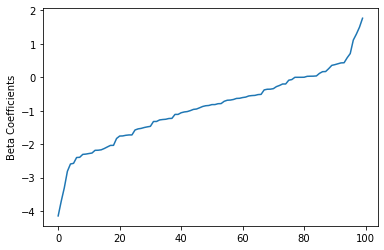

In [15]:
import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(lrModel.coefficients)

plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

In [16]:
len(lrModel.coefficients)

100

In [17]:
lrModel.getParam

<bound method Params.getParam of LogisticRegressionModel: uid = LogisticRegression_a2d96bb6ecd2, numClasses = 2, numFeatures = 100>

In [18]:
df.select('features').show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------+
|features                                                                                                     |
+-------------------------------------------------------------------------------------------------------------+
|(100,[0,13,24,35,45,49,52,53,94,95,96,99],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,25.0,226802.0,7.0,40.0])          |
|(100,[0,8,23,39,43,48,52,53,94,95,96,99],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,38.0,89814.0,9.0,50.0])            |
|(100,[2,14,23,41,43,48,52,53,94,95,96,99],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,28.0,336951.0,12.0,40.0])         |
|(100,[0,9,23,35,43,49,52,53,94,95,96,97,99],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,44.0,160323.0,10.0,7688.0,40.0])|
|(100,[3,9,24,36,45,48,53,94,95,96,99],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,18.0,103497.0,10.0,30.0])                 |
+-------------------------------------------------------------------------------------------------------

### ROC曲线

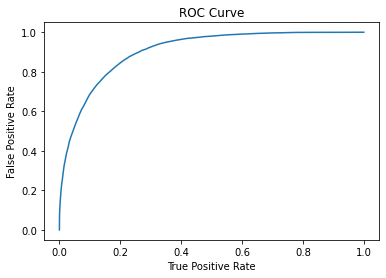

Training set areaUnderROC: 0.9053203979426604


In [19]:
trainingSummary = lrModel.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [20]:
trainingSummary.accuracy

0.8516712888629397

In [21]:
trainingSummary.recallByLabel

[0.930484767196781, 0.5996323529411764]

### P-R曲线

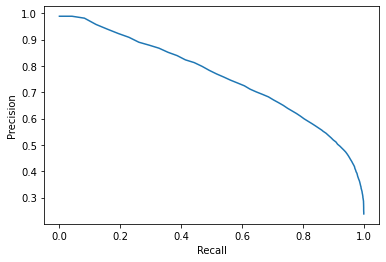

In [22]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [23]:
predictions = lrModel.transform(test)
predictions.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- educational-num: integer (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- capital-gain: integer (nullable = true)
 |-- capital-loss: integer (nullable = true)
 |-- hours-per-week: integer (nullable = true)
 |-- native-country: string (nullable = true)
 |-- income: string (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [24]:
predictions.select('age', 'workclass', 'label', 'prediction', 'probability').show(10)

+---+---------+-----+----------+--------------------+
|age|workclass|label|prediction|         probability|
+---+---------+-----+----------+--------------------+
| 26|  Private|  0.0|       0.0|[0.69373398473136...|
| 30|  Private|  0.0|       0.0|[0.61163146131025...|
| 31|  Private|  0.0|       0.0|[0.66067198545007...|
| 32|  Private|  0.0|       0.0|[0.66129318473475...|
| 34|  Private|  0.0|       0.0|[0.66321478729754...|
| 42|  Private|  0.0|       0.0|[0.59434501021237...|
| 44|  Private|  0.0|       0.0|[0.63019843473569...|
| 46|  Private|  0.0|       0.0|[0.55415966774049...|
| 50|  Private|  0.0|       1.0|[0.23930740869415...|
| 51|  Private|  0.0|       0.0|[0.59487677535937...|
+---+---------+-----+----------+--------------------+
only showing top 10 rows



In [25]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print('Test Area Under ROC', evaluator.evaluate(predictions))
print('Test Area Under PR', evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"}))

Test Area Under ROC 0.9023600168373193
Test Area Under PR 0.7609591723515756


In [26]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)

print('Test Area Under ROC', evaluator.evaluate(predictions))
print('Test Area Under PR', evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"}))

Test Area Under ROC 0.9014836720704342
Test Area Under PR 0.7579763609960857


In [27]:
bestModel = cvModel.bestModel
final_predictions = bestModel.transform(test)
print(evaluator.evaluate(final_predictions))
print(evaluator.evaluate(final_predictions, {evaluator.metricName: "areaUnderPR"}))

0.9014836720704339
0.7579763609960856


### SVM

In [28]:
from pyspark.ml.classification import LinearSVC

svm = LinearSVC(featuresCol = 'features', labelCol = 'label')
svmModel = svm.fit(train)

In [29]:
predictions = svmModel.transform(test)
predictions.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- educational-num: integer (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- capital-gain: integer (nullable = true)
 |-- capital-loss: integer (nullable = true)
 |-- hours-per-week: integer (nullable = true)
 |-- native-country: string (nullable = true)
 |-- income: string (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [30]:
predictions.select('age', 'workclass', 'label','prediction', 'rawPrediction').show(10)

+---+---------+-----+----------+--------------------+
|age|workclass|label|prediction|       rawPrediction|
+---+---------+-----+----------+--------------------+
| 26|  Private|  0.0|       0.0|[0.41304013964250...|
| 30|  Private|  0.0|       0.0|[0.33020191137841...|
| 31|  Private|  0.0|       0.0|[0.37572020722137...|
| 32|  Private|  0.0|       0.0|[0.37547860053942...|
| 34|  Private|  0.0|       0.0|[0.40106742452565...|
| 42|  Private|  0.0|       0.0|[0.30932623049513...|
| 44|  Private|  0.0|       0.0|[0.36098707281014...|
| 46|  Private|  0.0|       0.0|[0.29031067044792...|
| 50|  Private|  0.0|       1.0|[-0.1252004496850...|
| 51|  Private|  0.0|       0.0|[0.32250515869763...|
+---+---------+-----+----------+--------------------+
only showing top 10 rows



In [31]:
evaluator = BinaryClassificationEvaluator()
print(evaluator.evaluate(predictions))
print(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"}))

0.8981309772045263
0.761550850681381


In [32]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

cv = CrossValidator(estimator=svm, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)

print('Test Area Under ROC', evaluator.evaluate(predictions))
print('Test Area Under PR', evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"}))

Test Area Under ROC 0.8981309772045192
Test Area Under PR 0.7615508506813805


### Decision Trees

In [33]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)

In [34]:
print("numNodes = ", dtModel.numNodes)
print("depth = ", dtModel.depth)

numNodes =  11
depth =  3


In [35]:
predictions = dtModel.transform(test)
predictions.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- educational-num: integer (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- capital-gain: integer (nullable = true)
 |-- capital-loss: integer (nullable = true)
 |-- hours-per-week: integer (nullable = true)
 |-- native-country: string (nullable = true)
 |-- income: string (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [36]:
predictions.select('age', 'workclass', 'label', 'prediction', 'probability').show(10)

+---+---------+-----+----------+--------------------+
|age|workclass|label|prediction|         probability|
+---+---------+-----+----------+--------------------+
| 26|  Private|  0.0|       0.0|[0.70786747358703...|
| 30|  Private|  0.0|       0.0|[0.70786747358703...|
| 31|  Private|  0.0|       0.0|[0.70786747358703...|
| 32|  Private|  0.0|       0.0|[0.70786747358703...|
| 34|  Private|  0.0|       0.0|[0.70786747358703...|
| 42|  Private|  0.0|       0.0|[0.70786747358703...|
| 44|  Private|  0.0|       0.0|[0.70786747358703...|
| 46|  Private|  0.0|       0.0|[0.70786747358703...|
| 50|  Private|  0.0|       0.0|[0.70786747358703...|
| 51|  Private|  0.0|       0.0|[0.70786747358703...|
+---+---------+-----+----------+--------------------+
only showing top 10 rows



In [37]:
evaluator = BinaryClassificationEvaluator()
print(evaluator.evaluate(predictions))
print(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"}))

0.7461830231369375
0.5639833789425752


In [38]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [1, 2, 6, 10])
             .addGrid(dt.maxBins, [20, 40, 80])
             .build())

cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)

print(evaluator.evaluate(predictions))
print(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"}))

0.7933843852974034
0.5887407089034857


In [39]:
bestModel = cvModel.bestModel
final_predictions = bestModel.transform(test)
print(evaluator.evaluate(final_predictions))
print(evaluator.evaluate(final_predictions, {evaluator.metricName: "areaUnderPR"}))

0.7933843852974034
0.5887407089034858


In [40]:
print("numNodes = ", cvModel.bestModel.numNodes)
print("depth = ", cvModel.bestModel.depth)

numNodes =  7
depth =  2


### Random Forest

In [41]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)

In [42]:
predictions = rfModel.transform(test)
predictions.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- educational-num: integer (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- capital-gain: integer (nullable = true)
 |-- capital-loss: integer (nullable = true)
 |-- hours-per-week: integer (nullable = true)
 |-- native-country: string (nullable = true)
 |-- income: string (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [43]:
predictions.select('age', 'workclass', 'label', 'prediction', 'probability').show(10)

+---+---------+-----+----------+--------------------+
|age|workclass|label|prediction|         probability|
+---+---------+-----+----------+--------------------+
| 26|  Private|  0.0|       0.0|[0.67680126837824...|
| 30|  Private|  0.0|       0.0|[0.66570564350408...|
| 31|  Private|  0.0|       0.0|[0.66570564350408...|
| 32|  Private|  0.0|       0.0|[0.66570564350408...|
| 34|  Private|  0.0|       0.0|[0.68373220156405...|
| 42|  Private|  0.0|       0.0|[0.66570564350408...|
| 44|  Private|  0.0|       0.0|[0.68373220156405...|
| 46|  Private|  0.0|       0.0|[0.68373220156405...|
| 50|  Private|  0.0|       0.0|[0.66570564350408...|
| 51|  Private|  0.0|       0.0|[0.68373220156405...|
+---+---------+-----+----------+--------------------+
only showing top 10 rows



In [44]:
evaluator = BinaryClassificationEvaluator()
print(evaluator.evaluate(predictions))
print(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"}))

0.8933684657391131
0.7409535574427896


In [45]:
paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [2, 4, 6])
             .addGrid(rf.maxBins, [20, 60])
             .addGrid(rf.numTrees, [5, 20])
             .build())

cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)

print(evaluator.evaluate(predictions))
print(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"}))

0.8959638151772569
0.7465535064217794


In [46]:
bestModel = cvModel.bestModel
final_predictions = bestModel.transform(test)
print(evaluator.evaluate(final_predictions))
print(evaluator.evaluate(final_predictions, {evaluator.metricName: "areaUnderPR"}))

0.8959638151772569
0.7465535064217785


### Gradient-boosted Decision Tree

In [47]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10, )
gbtModel = gbt.fit(train)

In [48]:
predictions = gbtModel.transform(test)
predictions.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- educational-num: integer (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- capital-gain: integer (nullable = true)
 |-- capital-loss: integer (nullable = true)
 |-- hours-per-week: integer (nullable = true)
 |-- native-country: string (nullable = true)
 |-- income: string (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [146]:
predictions.select('age', 'workclass', 'income', 'label', 'prediction', 'probability').show(10)

+---+---------+------+-----+----------+--------------------+
|age|workclass|income|label|prediction|         probability|
+---+---------+------+-----+----------+--------------------+
| 26|  Private| <=50K|  0.0|       0.0|[0.78666932495358...|
| 30|  Private| <=50K|  0.0|       0.0|[0.75419416340672...|
| 31|  Private| <=50K|  0.0|       0.0|[0.76221794329439...|
| 32|  Private| <=50K|  0.0|       0.0|[0.76221794329439...|
| 34|  Private| <=50K|  0.0|       0.0|[0.62124661728836...|
| 42|  Private| <=50K|  0.0|       0.0|[0.57926672264498...|
| 44|  Private| <=50K|  0.0|       0.0|[0.58914494141653...|
| 46|  Private| <=50K|  0.0|       0.0|[0.58914494141653...|
| 50|  Private| <=50K|  0.0|       0.0|[0.58022130871171...|
| 51|  Private| <=50K|  0.0|       0.0|[0.59803324918263...|
+---+---------+------+-----+----------+--------------------+
only showing top 10 rows



In [50]:
evaluator = BinaryClassificationEvaluator()
print(evaluator.evaluate(predictions))
print(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"}))

0.9080935316348022
0.7804716580030359


In [51]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6]) #最大树深
             .addGrid(gbt.maxBins, [20, 60]) #最大的划分数
             .addGrid(gbt.maxIter, [10, 20]) #最大迭代次数
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)
print(evaluator.evaluate(predictions))
print(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"}))

0.917747218435313
0.8115429555872634


In [52]:
bestModel = cvModel.bestModel
final_predictions = bestModel.transform(test)
print(evaluator.evaluate(final_predictions))
print(evaluator.evaluate(final_predictions, {evaluator.metricName: "areaUnderPR"}))

0.917747218435313
0.8115429555872625


In [171]:
from pyspark.ml.linalg import SparseVector, DenseVector

importance = bestModel.featureImportances
importance_dense = DenseVector(importance)
importance_df = pd.DataFrame(importance_dense.array)
importance_df.columns = ['weights']
importance_df = importance_df.sort_values(by='weights', ascending=False)
writer = pd.ExcelWriter('featureImportances_sorted.xlsx')
importance_df.to_excel(writer, sheet_name='featureImportances_sorted')
writer.save()

In [172]:
pd.set_option("display.max_rows",100)
importance_df

,weights
97,0.204320
23,0.191743
94,0.097765
99,0.082316
96,0.067811
98,0.045293
31,0.041228
95,0.030503
29,0.025068
1,0.018136


In [55]:
df.select('features').show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------+
|features                                                                                                     |
+-------------------------------------------------------------------------------------------------------------+
|(100,[0,13,24,35,45,49,52,53,94,95,96,99],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,25.0,226802.0,7.0,40.0])          |
|(100,[0,8,23,39,43,48,52,53,94,95,96,99],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,38.0,89814.0,9.0,50.0])            |
|(100,[2,14,23,41,43,48,52,53,94,95,96,99],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,28.0,336951.0,12.0,40.0])         |
|(100,[0,9,23,35,43,49,52,53,94,95,96,97,99],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,44.0,160323.0,10.0,7688.0,40.0])|
|(100,[3,9,24,36,45,48,53,94,95,96,99],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,18.0,103497.0,10.0,30.0])                 |
+-------------------------------------------------------------------------------------------------------

In [185]:
df.select('label').show(5, truncate=False)

+-----+
|label|
+-----+
|0.0  |
|0.0  |
|1.0  |
|1.0  |
|0.0  |
+-----+
only showing top 5 rows



In [80]:
df

DataFrame[label: double, features: vector, age: int, workclass: string, fnlwgt: int, education: string, educational-num: int, marital-status: string, occupation: string, relationship: string, race: string, gender: string, capital-gain: int, capital-loss: int, hours-per-week: int, native-country: string, income: string]

In [88]:
pdf = pd.DataFrame(df.drop('label').drop('features').collect(), columns=df.drop('label').drop('features').columns)

In [89]:
pdf

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [99]:
len(pdf.columns)

15

In [101]:
for i in range(len(pdf.columns)):
    col = columns[i]
    print('{}:{}'.format(pdf.columns[i], len(pdf[col].unique())))

age:74
workclass:9
fnlwgt:28523
education:16
educational-num:16
marital-status:7
occupation:15
relationship:6
race:5
gender:2
capital-gain:123
capital-loss:99
hours-per-week:96
native-country:42
income:2


In [104]:
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [109]:
indices = [1, 3, 5, 6, 7, 8, 9, 13]
cnt=0
for i in indices:
    col = columns[i]
    lens = len(pdf[col].unique())
    cnt += tmp - 1
    print('{}:{}'.format(pdf.columns[i], lens))
print(cnt)

workclass:9
education:16
marital-status:7
occupation:15
relationship:6
race:5
gender:2
native-country:42
94


In [154]:
temp = 0
for col in categoricalColumns:
    lens = len(pdf[col].unique()) - 1
    print('{}:{} - {}'.format(col, temp, temp+lens-1))
    temp += lens

print('-' * 30)    
    
for col in numericCols:
    print('{}:{}'.format(col, temp))
    temp += 1

workclass:0 - 7
education:8 - 22
marital-status:23 - 28
occupation:29 - 42
relationship:43 - 47
race:48 - 51
gender:52 - 52
native-country:53 - 93
------------------------------
age:94
fnlwgt:95
educational-num:96
capital-gain:97
capital-loss:98
hours-per-week:99


In [149]:
categoricalColumns

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'gender',
 'native-country']

In [148]:
numericCols

['age',
 'fnlwgt',
 'educational-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

In [156]:
len(pdf)

48842

In [183]:
def function(col):
    unique = pdf[col].unique()
    dict = {}
    for status in unique:
        dict[status] = len(pdf[pdf[col] == status])   
    dict_order=sorted(dict.items(),key=lambda x:x[1],reverse=True) 
    print('{} : {}'.format(col, dict_order))

In [184]:
for col in categoricalColumns:
    function(col)
    print('\n')

workclass : [('Private', 33906), ('Self-emp-not-inc', 3862), ('Local-gov', 3136), ('?', 2799), ('State-gov', 1981), ('Self-emp-inc', 1695), ('Federal-gov', 1432), ('Without-pay', 21), ('Never-worked', 10)]


education : [('HS-grad', 15784), ('Some-college', 10878), ('Bachelors', 8025), ('Masters', 2657), ('Assoc-voc', 2061), ('11th', 1812), ('Assoc-acdm', 1601), ('10th', 1389), ('7th-8th', 955), ('Prof-school', 834), ('9th', 756), ('12th', 657), ('Doctorate', 594), ('5th-6th', 509), ('1st-4th', 247), ('Preschool', 83)]


marital-status : [('Married-civ-spouse', 22379), ('Never-married', 16117), ('Divorced', 6633), ('Separated', 1530), ('Widowed', 1518), ('Married-spouse-absent', 628), ('Married-AF-spouse', 37)]


occupation : [('Prof-specialty', 6172), ('Craft-repair', 6112), ('Exec-managerial', 6086), ('Adm-clerical', 5611), ('Sales', 5504), ('Other-service', 4923), ('Machine-op-inspct', 3022), ('?', 2809), ('Transport-moving', 2355), ('Handlers-cleaners', 2072), ('Farming-fishing', 1